In [3]:
# k-means clustering
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [4]:
NUM_VERTIPORTS = 160
NUM_VERTIHUBS = 12
MINUTES_OF_DATA = 1
USES_ADDITIONAL_VERTHUBS = True

In [5]:
df = pd.read_csv('data/Realtime/OpsLimits/zone17_lat_long.csv')
df = df.drop(columns=['Unnamed: 0'])
df

,zone,lat,long
0,4,41.894749,-87.630593
1,3,41.894694,-87.635477
2,11,41.891098,-87.630498
3,10,41.891045,-87.635384
4,2,41.894628,-87.640390
5,1,41.894558,-87.645271
6,9,41.890977,-87.640266
7,8,41.890916,-87.645154
8,17,41.887440,-87.630395
9,16,41.887380,-87.635278


In [6]:
def k_means(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(data[:,[0,1]])
    labels = kmeans.labels_
    plt.scatter(data[:,0], data[:,1], c=['tab:blue' for i in labels], alpha=.5, label='Zone', s=20)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=50,c='tab:orange', label='Vertiport - Centroid')
    plt.ylabel("Latitude")
    plt.xlabel("Longitude")
    plt.legend()
    plt.title("K-Means Zone Clusters")
    plt.savefig('data/Realtime/OpsLimits/zones_to_towers_' + str(NUM_VERTIHUBS) + '.png', dpi=216)
    plt.show()
    return kmeans


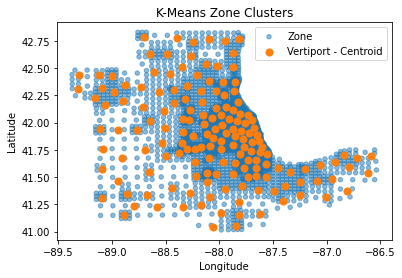

In [7]:
import copy
formatted_df = copy.deepcopy(df)
formatted_df['color'] = [float(0.5) for i in range(len(formatted_df['lat']))]
formatted_df = formatted_df[['long','lat','color']].to_numpy()
kmeans = k_means(formatted_df, NUM_VERTIPORTS)

In [8]:
def duplicate_vertihub(vertihub_to_duplicate: int, new_vertihub_number : int, num_duplications : int, vertihubs_to_vertiports, column_header : str):
    # find the vertiports associated with the original vertihub
    vertiports = []
    for idx, vertihub in enumerate(vertihubs_to_vertiports['vertihub_0']):
        if vertihub == vertihub_to_duplicate:
            vertiports.append(idx)
    
    for i in range(num_duplications):
        for vertiport in vertiports:
            vertihubs_to_vertiports[column_header + str(i+1)][vertiport] = new_vertihub_number
            vertihubs_to_vertiports['num_vertihubs'][vertiport] += 1
        new_vertihub_number += 1
    

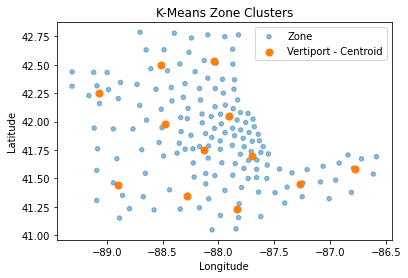

,vertiport,long,lat,num_vertihubs,vertihub_0,vertihub_1
0,0,-87.867935,42.113023,2,5,12
1,1,-87.983678,41.755379,2,1,14
2,2,-88.996864,42.431453,1,0,-1
3,3,-87.008659,41.319802,1,2,-1
4,4,-87.706935,41.735222,2,11,13
5,5,-88.370978,41.721233,2,1,14
6,6,-88.705400,42.141602,2,6,15
7,7,-88.160202,42.189399,2,5,12
8,8,-88.940794,41.460231,1,4,-1
9,9,-88.095275,42.762673,1,3,-1


In [9]:
# cluster centers = tower, cluster these towers for determing rendezvous points
tower_locations = kmeans.cluster_centers_

vertihubs_to_vertiports = pd.DataFrame()
vertihubs_to_vertiports['vertiport'] = [i for i in range(NUM_VERTIPORTS)]

vertihubs_to_vertiports['long'] = copy.deepcopy(tower_locations[:,0])
vertihubs_to_vertiports['lat'] = copy.deepcopy(tower_locations[:,1])
vertihubs_to_vertiports['color'] = [.5 for i in range(len(vertihubs_to_vertiports['lat']))]

tower_locations_formatted = vertihubs_to_vertiports[['long','lat','color']].to_numpy()

vertiport_kmeans = k_means(tower_locations_formatted, NUM_VERTIHUBS)
vertihubs_to_vertiports['num_vertihubs'] = [1 for i in range(NUM_VERTIPORTS)]
vertihubs_to_vertiports['vertihub_0'] = vertiport_kmeans.labels_
vertihubs_to_vertiports.drop(columns='color', inplace=True)

num_vertihub_columns = 1 #kind of a global variable. need to use this when assigning requests to vertihubs
total_additional_vertihubs = 0  # same as above - need this for saving the request mapping csv
if USES_ADDITIONAL_VERTHUBS:
    vertihubs_to_duplicate = [(5,1), (11, 1), (1, 1), (6, 1)] # (vertihub name, num times to dupe)
    num_vertihub_columns += max([i[1] for i in vertihubs_to_duplicate])

    # prepping the columns for storing additional vertihubs
    column_header = 'vertihub_'
    for i in range(1, num_vertihub_columns): 
        curr_header = column_header + str(i)
        vertihubs_to_vertiports[curr_header] = [-1 for i in range(NUM_VERTIPORTS)]
    
    total_additional_vertihubs = sum([i[1] for i in vertihubs_to_duplicate])
    total_vertihubs = NUM_VERTIHUBS
    for vertihub, num_duplications in vertihubs_to_duplicate:
        duplicate_vertihub(vertihub, total_vertihubs, num_duplications, vertihubs_to_vertiports, column_header)
        total_vertihubs += num_duplications
        
    vertihubs_to_vertiports.to_csv(
        'data/Realtime/OpsLimits/vertiports_' + 
        str(NUM_VERTIHUBS + total_additional_vertihubs) + 
        '_additional_vhubs_' + 
        str(total_additional_vertihubs) + '.csv',
        index=False)
else:
    vertihubs_to_vertiports.to_csv('data/Realtime/OpsLimits/vertiports_' + str(NUM_VERTIHUBS) + '.csv', index=False)
# these are actually vertihubs (orange) and vertiports (blue)
vertihubs_to_vertiports

In [10]:
# now that each zone is assigned to a vertiport, lets change our flights from zone->zone to vertiport->vertiport

# NOTE: THIS DATA SET IS NOT INCLUDED WITH THE REPOSITORY AS IT IS A LARGE FILE. Please contact me (joeymuffoletto10@gmail.com) or Dr. Natasha Neogi (natasha.a.neogi@nasa.gov)
trips_from_work = pd.read_csv('data/Realtime/OpsLimits/commute_trips_fr_work_hhincome_all_chicago_matlab.csv')
time = trips_from_work['time']



In [11]:
import datetime


TIME_RANGE_START = datetime.time(15,0,0)
TIME_RANGE_END = datetime.time(15,MINUTES_OF_DATA, 0)

In [12]:
# convert to datetime.time objects
trips_between_start_end = [] 
for row in trips_from_work.itertuples(index=False):
    as_datetime = datetime.datetime.fromisoformat(row[0]).time()
    if as_datetime >= TIME_RANGE_START and as_datetime <= TIME_RANGE_END:
        trips_between_start_end.append((as_datetime, row[1], row[2], 
                                        row[3], row[4]))
print(trips_between_start_end[0])
print(len(trips_between_start_end))



(datetime.time(15, 0), 41.872817237190496, -87.62521525790109, 41.9285705028365, -87.6828779138215)
9503


In [13]:
from math import cos, asin, sqrt, pi

# def dist(x1, y1, x2, y2):
#     return math.sqrt((y2-y1)**(y2-y1) + (x2-x1)**(x2-x1))
def ll_distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) #2*R*asin...   
    

In [14]:
# for these trips, convert their longlat origin and destination coordinate to the nearest tower

tower_locations = kmeans.cluster_centers_
# print(tower_locations)
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple', 'tab:brown', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_map = {i : color for i, color in enumerate(colors)}

frame = pd.DataFrame()
frame['long'] = copy.deepcopy(tower_locations[:,0])
frame['lat'] = copy.deepcopy(tower_locations[:,1])
frame['color'] = [.5 for i in range(len(frame['lat']))]

tower_to_rendezvous = frame
tower_to_rendezvous['tower'] = [i for i in range(NUM_VERTIPORTS)] 

formatted_trips = []
min_time = datetime.datetime.combine(datetime.date.min, min(trips_between_start_end)[0])
vertiport_trip_index = [0 for i in range(NUM_VERTIPORTS)] # default to 0 (vertihub_0). 
for trip in trips_between_start_end:
    time, origin_lat, origin_long, dest_lat, dest_long = trip
    origin = min([(ll_distance(origin_lat, origin_long, other_lat, other_long), tower) 
                  for other_lat, other_long, tower in 
                  zip(tower_to_rendezvous['lat'],
                    tower_to_rendezvous['long'],
                     tower_to_rendezvous['tower']
                     )
                 ])
    destination = min([(ll_distance(dest_lat, dest_long, other_lat, other_long), tower) 
                  for other_lat, other_long, tower in 
                  zip(tower_to_rendezvous['lat'],
                    tower_to_rendezvous['long'],
                     tower_to_rendezvous['tower']
                     )
                 ])
    normalized_time_in_seconds = (datetime.datetime.combine(datetime.date.min, time) - min_time).seconds # each time step is one second
    origin_vertiport = origin[1]
    destination_vertiport = destination[1]
    origin_vertihub = vertihubs_to_vertiports['vertihub_0'][origin_vertiport] #NOTE: the origin will never be one of the "additional" vertihubs -> this doesn't matter...yet
      #NOTE: very weird. basically, later on when you use the trips, you end up dropping ones which have the same origin and destination vertihubs. Lets do this right now so that we don't end up with garbage date that we have to deal with later
    # this fix accommadates for additional vertihubs
    if origin_vertihub == vertihubs_to_vertiports['vertihub_0'][destination_vertiport]:
      continue # dont add the trip!

    # if vertihubs_to_vertiports['vertihub_' + str(vertiport_trip_index[destination_vertiport])][destination_vertiport] == -1:
    #   vertiport_trip_index[destination_vertiport] = 0
    assert(vertihubs_to_vertiports['vertihub_' + str(vertiport_trip_index[destination_vertiport])][destination_vertiport] != -1)
    destination_vertihub = vertihubs_to_vertiports['vertihub_' + str(vertiport_trip_index[destination_vertiport])][destination_vertiport]

    vertiport_trip_index[destination_vertiport] = (vertiport_trip_index[destination_vertiport] + 1)%vertihubs_to_vertiports['num_vertihubs'][destination_vertiport] # the modulo value (after the percent sign) is the number of vertihubs that this port is mapped to. Default is 1

    

    formatted_trips.append((normalized_time_in_seconds, origin_vertihub, origin_vertiport, destination_vertihub, destination_vertiport)) # seconds from start time of simulation
# print (formatted_trips)

In [15]:
trips_df = pd.DataFrame(formatted_trips, columns=['Time', 'OriginVertihub','OriginVertiport', 'DestinationVertihub', 'DestinationVertiport'])
path = 'data/Realtime/OpsLimits/trips_' + str(NUM_VERTIHUBS+total_additional_vertihubs) + '_minutes-' + str(MINUTES_OF_DATA)
if USES_ADDITIONAL_VERTHUBS:
    trips_df.to_csv(path + '_additional_vhubs_' + str(total_additional_vertihubs) + '.csv', index=False)
else:
    trips_df.to_csv(path + '.csv', index=False)
trips_df

,Time,OriginVertihub,OriginVertiport,DestinationVertihub,DestinationVertiport
0,0,11,38,5,128
1,60,1,137,11,83
2,60,5,119,11,38
3,60,0,124,9,49
4,0,5,67,6,88
5,0,5,128,13,38
6,60,8,59,2,87
7,0,11,39,8,57
8,0,5,140,0,25
9,0,9,100,3,58
